In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reset -f

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import os
import lmdb

from google.protobuf import text_format
from PIL import Image
import StringIO
import caffe
import caffe.draw
from caffe.proto import caffe_pb2
caffe.set_mode_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import python.helpers as helpers

In [28]:
solverPrototxt = "models/mnist2_solver.prototxt"
trainingPrototxt = "models/mnist2_train_test.prototxt"
testingPrototxt = "models/mnist2_deploy.prototxt"

trainingLogFile = "logs/train_mnist2.log"
testingData ="bin/mnist_test_lmdb"

trainedModel = "snapshots/mnist2_iter_10000.caffemodel"

In [37]:
#Visualize
netDesc = caffe_pb2.NetParameter()
text_format.Merge(open(trainingPrototxt).read(), netDesc)
image = Image.open(StringIO.StringIO(caffe.draw.draw_net(netDesc, "TB")))
image.show()

In [30]:
#Train the net
os.system("bash run_training_pipeline.sh mnist --arch2 --train --gray")

0

In [31]:
net = caffe.Net(trainingPrototxt, trainedModel, caffe.TEST)

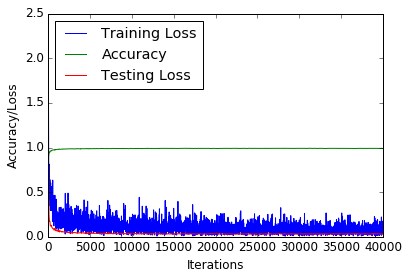

Baseline training loss 2.31551
Baseline test accuracy 0.0979
Final training loss 0.0310159
Final test accuracy 0.9903


In [38]:
#Show training graph
matplotlib.rcParams.update({'font.size': 12})
iterations, losses = helpers.getTrainingLossFromTrainingFile(trainingLogFile)
plt.plot(iterations, losses, label="Training Loss")

iterations, accuracy = helpers.getAccuracyFromTrainingFile(trainingLogFile)
plt.plot(iterations, accuracy, label="Accuracy")

iterations, losses = helpers.getTestingLossFromTrainingFile(trainingLogFile)
plt.plot(iterations, losses, label="Testing Loss")

plt.xlabel("Iterations")
plt.ylabel("Accuracy/Loss")

plt.legend(loc='upper left')

plt.show()

print "Baseline training loss " + losses[0]
print "Baseline test accuracy " + accuracy[0]

print "Final training loss " + losses[-1]
print "Final test accuracy " + accuracy[-1]

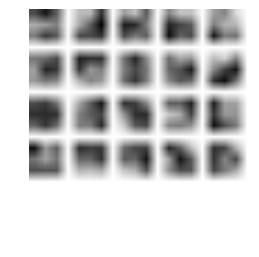

In [33]:
#Visualize learned filters from first layer
filters = net.params["conv1"][0].data
helpers.showFilterGrid(filters.transpose(0, 2, 3, 1), True)

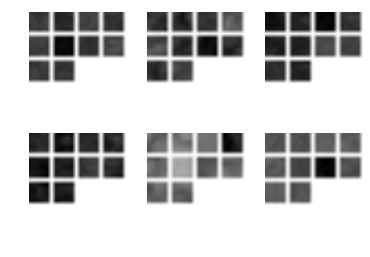

In [34]:
#Visualize some learned filters from second layer.
#Normalize them for good measure
numFilters = 6
gridSize = (int(np.ceil(numFilters/3.0)), 3)
for i in np.arange(0,numFilters):
    filters = net.params["conv2"][0].data[:,i:i+1,:,:]
    maxValue = np.amax(np.amax(filters, axis=2), axis=2)
    minValue = np.amax(np.amin(filters, axis=2), axis=2)
    filters = filters.transpose(2,3,0,1)
    filtersNormalized = filters - maxValue / (maxValue- minValue)
    filters = filtersNormalized.transpose(2,3,0,1)

    plt.subplot(gridSize[0],gridSize[1], i+1)
    helpers.showFilterGrid(filters.transpose(0, 2, 3, 1), True)
plt.show()

In [35]:
del net

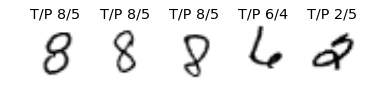

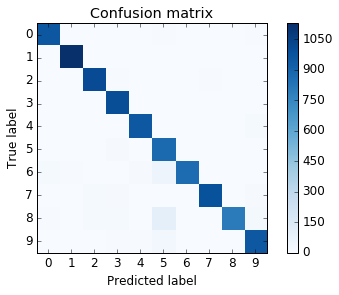

In [39]:
#Confusion matrix and eyeballing incorrect thru python using deploy model
net = caffe.Net(testingPrototxt, trainedModel, caffe.TEST)

caffe.set_mode_cpu()

lmbd_env = lmdb.open(testingData)
reader = helpers.lmdb_reader(lmbd_env)

numToEyeball = 5
numIncorrect = 0
groundTruths = np.empty((0), dtype=int)
predictions = np.empty((0), dtype=int)

for i, image, label in reader:
    out = net.forward_all(data=np.asarray([ image ]))
    
    prediction = int(out['prob'][0].argmax(axis=0))
    iscorrect = label == prediction
    groundTruths = np.append(groundTruths, label)
    predictions = np.append(predictions, prediction)

    if not iscorrect and numIncorrect < numToEyeball:
        numIncorrect += 1
        plt.subplot(1, numToEyeball, numIncorrect)
        plt.axis('off')
        plt.imshow(image.transpose(1,2,0)[:,:,0], cmap='gray')
        plt.title("T/P " + str(label) + "/" + str(prediction))

lmbd_env.close()      
plt.show()

helpers.showConfusionMatrix(helpers.getConfusionMatrix(groundTruths, predictions), np.arange(10))
plt.show()

del net